We will use here the same dataset we used in a [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/03.regression_contd-and-classification/c.classification.ipynb), to predict whether a video is high resolution (<720p) or low resolution

In [1]:

# The following is to be able to mount Google Drive
from google.colab import drive

mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


In [2]:
dataset_to_use = 'A'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"
filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name

--2025-09-29 09:23:11--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.A_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315832 (308K) [text/plain]
Saving to: ‘df.A_2.csv’

df.A_2.csv          100%[===================>] 308.43K  --.-KB/s    in 0.02s   

2025-09-29 09:23:11 (15.4 MB/s) - ‘df.A_2.csv’ saved [315832/315832]



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot


# Import the visualization and neural network libraries I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py
from visualization import plot_conf_mat
from neural_network_tools import enforce_reproducibility, make_sequential_model, train_model


import os
from os.path import isfile

from functools import partial

--2025-09-29 09:23:24--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.72K  --.-KB/s    in 0.001s  

2025-09-29 09:23:24 (22.4 MB/s) - ‘visualization.py’ saved [13023/13023]

--2025-09-29 09:23:24--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connec

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
import datetime # Import the datetime module


from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report



In [7]:
from imblearn.over_sampling import SMOTE

In [11]:
df = pd.read_csv(filename)
high_res = df['label_num']>=720

,label_num
0,False
1,False
2,True
3,False
4,False
...,...
287,True
288,False
289,False
290,True


In [15]:
X = df.drop(['label_num','RelativeTime'], axis=1) # Remove the label and
                      # the useless timestamp relativetime
X.head()

,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,BytesSent0,...,BufferProgress,BufferValid,KBytesReceived,label,KBytesReceived_log,PacketsSent_log,PacketsReceived_log,BytesSent_log,BytesReceived_log,BufferProgress_log
0,29,57,2372,79344,192.168.1.190,173.194.55.23,QUIC,29,57,2372,...,0.005177,True,79.344,q480p,4.373793,3.401197,4.060443,7.771910,11.281561,0.005164
1,7,39,625,52973,192.168.1.190,74.125.155.199,QUIC,4,36,384,...,0.004844,True,52.973,q360p,3.969782,2.079442,3.688879,6.439350,10.877557,0.004833
2,16,23,1056,34178,192.168.1.190,74.125.155.201,TCP,16,23,1056,...,0.005488,True,34.178,q720p,3.531582,2.833213,3.178054,6.963190,10.439367,0.005473
3,14,29,3377,36821,192.168.1.190,172.217.135.40,0,0,0,0,...,0.009311,True,36.821,q144p,3.606068,2.708050,3.401197,8.125039,10.513851,0.009268
4,9,77,900,104389,192.168.1.190,173.194.184.103,QUIC,9,77,900,...,0.006621,True,104.389,q360p,4.648124,2.302585,4.356709,6.803505,11.555889,0.006599


In [21]:
# Identify textual columns
text_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding to textual columns
X = pd.get_dummies(X, columns=text_cols, drop_first=True)

,PacketsSent,PacketsReceived,BytesSent,BytesReceived,PacketsSent0,PacketsReceived0,BytesSent0,BytesReceived0,PacketsSent1,PacketsReceived1,...,IPDst24_172.217.10.46,IPDst24_172.217.11.51,IPDst24_34.224.34.152,IPDst24_80.82.77.139,IPSrc25_0,label_q144p,label_q240p,label_q360p,label_q480p,label_q720p
0,29,57,2372,79344,29,57,2372,79344,0,0,...,False,False,False,False,True,False,False,False,True,False
1,7,39,625,52973,4,36,384,50112,2,2,...,False,False,False,False,True,False,False,True,False,False
2,16,23,1056,34178,16,23,1056,34178,0,0,...,False,False,False,False,False,False,False,False,False,True
3,14,29,3377,36821,0,0,0,0,11,28,...,False,False,False,False,True,True,False,False,False,False
4,9,77,900,104389,9,77,900,104389,0,0,...,False,False,False,False,True,False,False,True,False,False


In [22]:
# Convert the boolean Series 'high_res' to integer labels (0 and 1)
y = high_res.astype(int)

In [23]:
seed_=15

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=seed_)
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



We are performing binary classification. Therefore:
* **output neurons = 1**,
* **loss function = binary cross entropy**,
* **out_activation_function = sigmoid**.


In [26]:
num_of_output_neurons = 1 # Since we are performing a binary calassification
sample_size = X_train.shape[1]

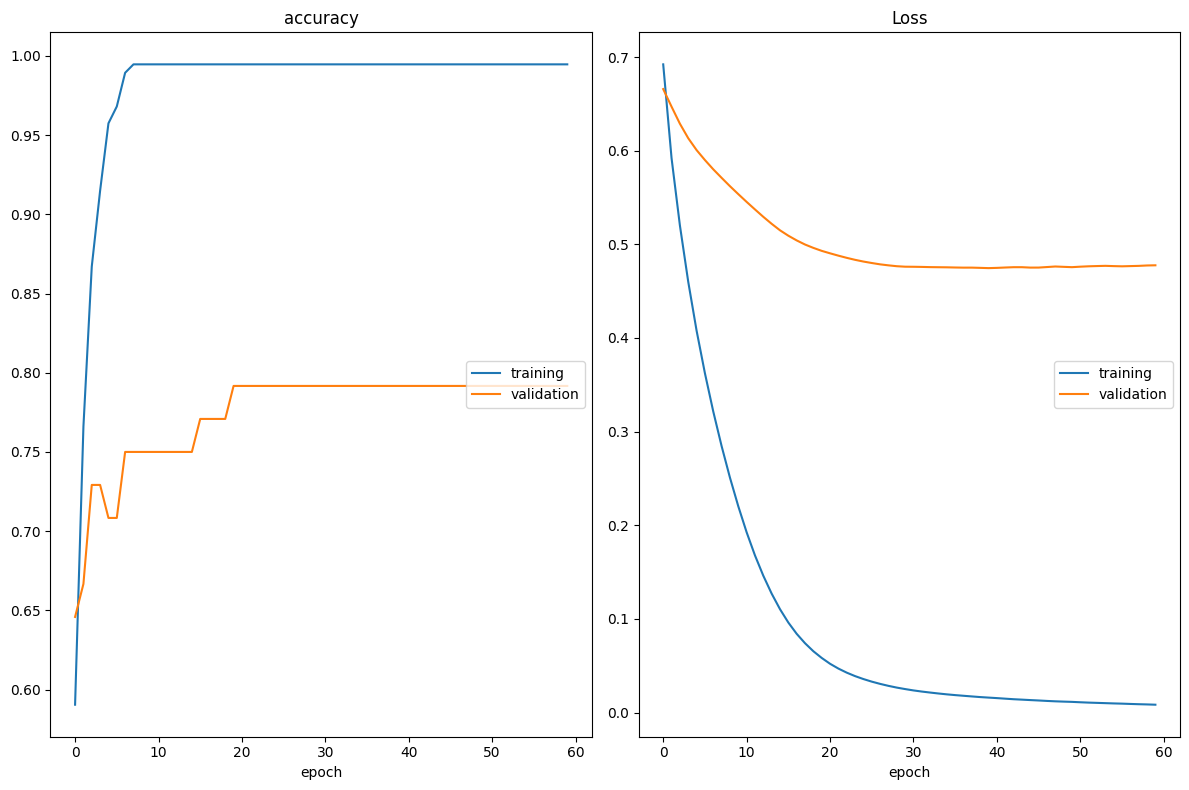

accuracy
	training         	 (min:    0.590, max:    0.995, cur:    0.995)
	validation       	 (min:    0.646, max:    0.792, cur:    0.792)
Loss
	training         	 (min:    0.008, max:    0.692, cur:    0.008)
	validation       	 (min:    0.475, max:    0.666, cur:    0.478)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9965 - loss: 0.0079 - val_accuracy: 0.7917 - val_loss: 0.4776
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 40.


In [31]:
architecture = [256, 128, 64, 32, num_of_output_neurons]
batch_size_=32
learning_rate_=0.0001

nn_file = my_path + 'nn-cc-big-no-dropout.keras'
model = make_sequential_model(sample_size, architecture,
                              loss_fun="binary_crossentropy",
                              out_activation_function="sigmoid",
                              learning_rate=learning_rate_)
history = train_model(model, nn_file, X_train, y_train, seed=seed_, max_epochs=800,
                      overwrite=True, patience=20,batch_size=batch_size_)

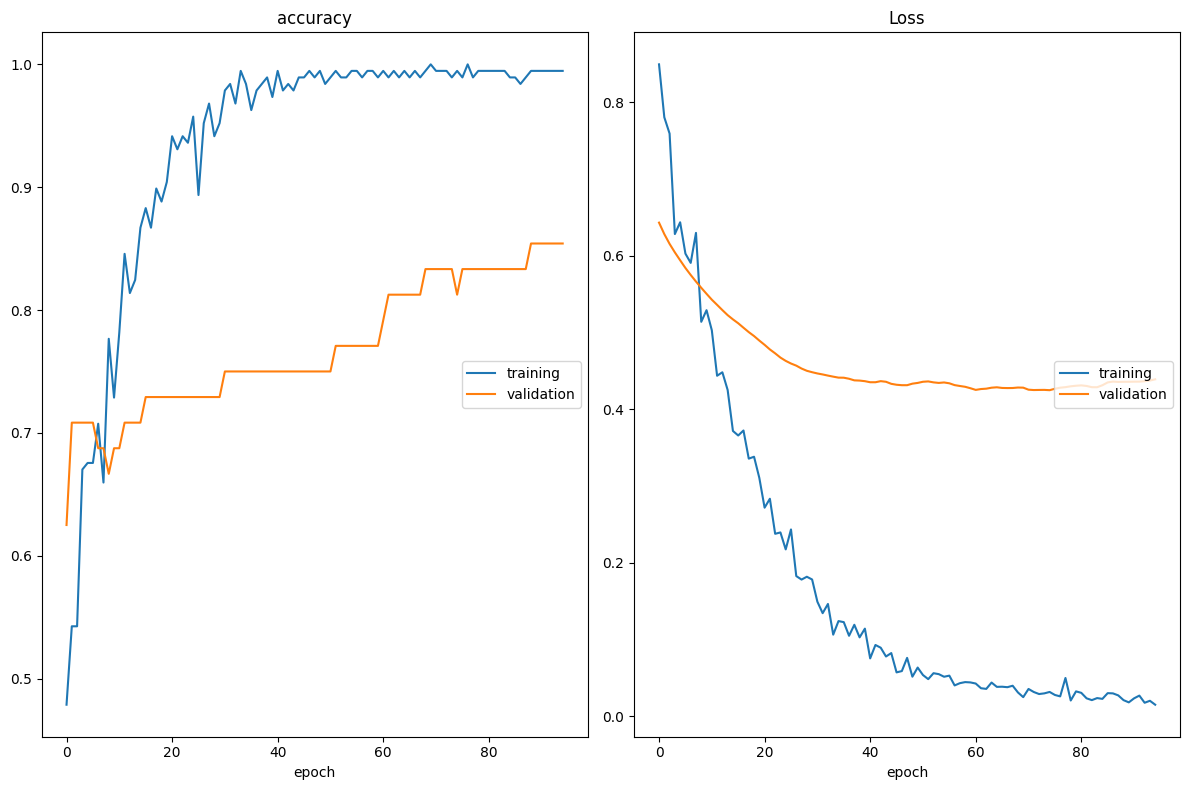

accuracy
	training         	 (min:    0.479, max:    1.000, cur:    0.995)
	validation       	 (min:    0.625, max:    0.854, cur:    0.854)
Loss
	training         	 (min:    0.015, max:    0.849, cur:    0.015)
	validation       	 (min:    0.425, max:    0.643, cur:    0.439)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9965 - loss: 0.0169 - val_accuracy: 0.8542 - val_loss: 0.4388
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 75.


In [32]:
nn_file = my_path + 'nn-cc-big-dropoutkp_0.3.keras'
model = make_sequential_model(sample_size, architecture,
                              loss_fun="binary_crossentropy",
                              out_activation_function="sigmoid",
                              dropout_keep_prob=0.75,
                              learning_rate=learning_rate_)
history = train_model(model, nn_file, X_train, y_train, seed=seed_, max_epochs=800,
                      overwrite=True, patience=20,batch_size=batch_size_)

It seems we improved a bit the validation error.
The improvement is not that great, but you can check if with your dataset dropout is more relevant.
We should check if the performance on the test set are actually better.